### 第一題 [分類器、特徵建構、與Stacking]

(50%) 建構分類器時常會透過特徵選擇與Ensemble增強預測能力。本題的目的是讓大家練習這些技巧。本題使用一個中文姓名分類的資料集。這個資料集收集了10730個中文名(不含姓)，以及這些名子對應到的性別。本資料集的資料檔是**namesex_data_v2.csv**，共有三個欄位，gname, sex, fold:
* gname: 不含姓的中文名。
* sex: 1為男性，0為女性。
* fold: 為0 - 9的整數，做為後續切割資料集使用。

我們先將這個資料集讀入Numpy Array，並列印前十筆資料

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
import numpy as np
import warnings
warnings.filterwarnings("ignore")

f = open('ds/namesex_data_v2.csv', 'r', encoding='utf8')
mydata = csv.DictReader(f)
sexlist = []
namelist = []
foldlist = []
for i, arow in enumerate(mydata):
    if i < 10:
        print(arow)
    sexlist.append(int(arow['sex'].strip()))
    gname = arow['gname'].strip()
    namelist.append(gname)
    foldlist.append(int(arow['fold'].strip()))

sexlist = np.asarray(sexlist)
namelist = np.asarray(namelist)
foldlist = np.asarray(foldlist)
f.close()

{'gname': '承憲', 'sex': '1', 'fold': '9'}
{'gname': '均平', 'sex': '1', 'fold': '7'}
{'gname': '思安', 'sex': '0', 'fold': '6'}
{'gname': '佑誠', 'sex': '1', 'fold': '3'}
{'gname': '乃馨', 'sex': '0', 'fold': '0'}
{'gname': '婕', 'sex': '0', 'fold': '0'}
{'gname': '冠瑜', 'sex': '0', 'fold': '1'}
{'gname': '冠學', 'sex': '1', 'fold': '0'}
{'gname': '立翰', 'sex': '1', 'fold': '2'}
{'gname': '以柔', 'sex': '0', 'fold': '6'}


接下來看一些統計數字:

In [2]:
nobs = namelist.shape[0]
print("資料筆數 = ", nobs)

資料筆數 =  10730


In [3]:
avg_sex = np.mean(sexlist)
print("男性比率", avg_sex)

男性比率 0.47940354147250697


這個資料集的男女比率還算是平均，男性佔了47.94%。

我們用了比較迂迴的方式讀檔案，Pandas其實可以直接讀csv檔。接下來做一些基本的資料分析。我們關心幾件事:
* 最常見的名子
* 共有多少個不重複的名子
* 有多少難判斷男女的名子

要回答這些問題，首先對名子加總，計算數量與男性比率，排序之後列出前20個名子:

In [4]:
import pandas as pd
name_df = pd.DataFrame({'sex': sexlist, 'name': namelist, 'fold': foldlist})
sex_tend = name_df[['name', 'sex']].groupby(["name"]).agg(['mean', 'count']).reset_index()
sex_tend.columns = ['-'.join(col).strip() for col in sex_tend.columns.values]
sex_tend = sex_tend.sort_values(['sex-count'], ascending=False)

print("最常見的20個名子:")
sex_tend.head(20)

最常見的20個名子:


name-  sex-mean  sex-count
3738    承恩  1.000000         20
918     冠廷  1.000000         20
2506    宜蓁  0.000000         18
545     佳穎  0.000000         16
3196    彥廷  0.923077         13
913     冠宇  1.000000         13
3390    思妤  0.000000         13
1019    凱翔  1.000000         13
3769    承翰  1.000000         13
3477    怡萱  0.000000         13
497     佳妤  0.000000         12
4683    柏翰  1.000000         12
2114    子瑜  0.090909         11
4907    欣妤  0.000000         11
1351    品妤  0.000000         10
7889    鈺婷  0.000000         10
2499    宜臻  0.000000          9
1441    哲瑋  1.000000          9
7024    芳瑜  0.000000          9
2140    子芸  0.000000          9

由上面的列表看來，最常見的男性名子是承恩與冠廷，最常見的女性名子是宜蓁與佳穎。而這些常見的名子男性比率都非常接近0或1，表示這些名子沒有性別混淆的問題。

另外一個問題是有多少名子只出現一次:

In [5]:
single_name = np.sum(sex_tend['sex-count'] <= 1)
print("出現一次名子個數: ", single_name, "比率:", single_name / nobs)

出現一次名子個數:  7067 比率: 0.6586206896551724


由結果看來，名子在資料集中只出現一次的比率很高，有65%。也就是說，如果單純的使用訓練資料中出現的名子做為特徵，模型應該會有很差的預測能力。

#### <font color=#800000>為了處理這個問題，我們在接下來的任務中，會使用"Unigram + Full Name"的特徵表示，比如說，"芳瑜"的特徵表示為"芳"、"瑜"，以及原始的名子"芳瑜"。</font>

最後我們來看看性別混淆的名子:

In [6]:
ind1 = (sex_tend['sex-mean'] > 0.4) & (sex_tend['sex-mean'] < 0.6)
sex_amb = sex_tend[ind1]
amb_count = sex_amb['sex-count'].sum()
print("難區分性別姓名數量: ", amb_count, "比率:", amb_count/ nobs)

難區分性別姓名數量:  136 比率: 0.012674743709226468


難以區分性別的名子總數並不高，所占總體資料的比率也很低，只有1.26%，因此不用擔心這個因素會影響預測準確率。

下面來看看幾個容易混淆性別的名子:

In [7]:
sex_amb.head()

name-  sex-mean  sex-count
6777    育瑋       0.5          4
338     以恩       0.5          4
7783    郁軒       0.5          4
2513    宜謙       0.5          4
5920    祐嘉       0.5          4

#### 實做限制
為了確保可以確實練習到重要技巧，禁用Pycaret (<https://pycaret.org/>) 這類可以自動化調教參數與Ensemble模型的工具。另外也禁止使用`sklearn.ensemble.Stacking.*`。你可以使用sklearn中Pre-processing工具函數與現成的分類器，但參數調教請自行處理。



#### 回答下面問題
#### Q1.1 (10%): 
使用One-hot Encoding建構資料變數。所有資料變數都要是Numpy Array。依照每筆資料其fold值切割為Training (fold <=6)、Validation (fold == 7)、Stacking (fold == 8)、Test (fold == 9)。每個資料集應有特徵Array(二維)以及Label Array(一維)。如前面提到的，每個名子應該要對應到全名以及單字的One-hot Encoding。比如說，"芳瑜"的特徵表示為"芳"、"瑜"，以及原始的名子"芳瑜"。建構特徵表示時應依照個特徵出現的頻率篩選。特徵在訓練資料出現兩次或以上才納入。如果一個特徵被排除，這個特徵出現時應被歸為"\_Other_Feature_"。任何名子只要有出現未被納入的特徵，則其"\_Other_Feature_"的欄位值為1。

舉例而言，假設訓練資料集中有下面三個名子: 承恩、承德、恩賜。在經過特徵頻率篩選之後，只剩下以下特徵: 承、恩。其他特徵，如承恩、承德、恩賜、德、賜皆被排除。因此最後的特徵表示為:

Input | 承 | 恩 | \_Other_Feature_ |
------|----|----|-----------------|
承恩  | 1  | 1   |  1    |
承德  | 1  | 0   |  1  |
恩賜  | 0  | 1   |  1 |

最後應產生以下Numpy Array:
* x_train: Training Features
* y_train: Training Labels
* x_valid: Validation Features
* y_valid: Validation Labels
* x_stack: Stack Features
* y_stack: Stack Labels
* x_test: Test Features
* y_test: Test Labels

請列出每個Numpy Array的Shape以資查驗。

### 依照每筆資料其fold值切割為Training (fold <=6)、Validation (fold == 7)、Stacking (fold == 8)、Test (fold == 9)資料集。

In [8]:
df = pd.read_csv('ds/namesex_data_v2.csv')
training = df[df['fold']<=6]
validation = df[df['fold']==7]
stacking = df[df['fold']==8]
testing = df[df['fold']==9]
x_train = training.loc[:,['gname']]
y_train = training['sex']
x_valid = validation.loc[:,['gname']]
y_valid = validation['sex']
x_stack = stacking.loc[:,['gname']]
y_stack = stacking['sex']
x_test = testing.loc[:,['gname']]
y_test = testing['sex'] 

### 使用One-hot Encoding建構資料變數

In [9]:
from collections import defaultdict
def filter_feature(train_data):
    names = train_data['gname'].copy()
    total_feature_names = defaultdict(int)
    for idx,name in enumerate(names.values):
        names = name.strip()
        if len(names) > 1:
            names = np.array(list(names)+[names])
        else:
            names = np.array([names])
        for feature in names:
            total_feature_names[feature] += 1
            
    total_feature_names = dict(filter(lambda x : x[1]>=2 , total_feature_names.items()))
    total_feature_names.update({'_Other_Feature_':0})
    return list(total_feature_names.keys())

def onehotencoding_feature(train_data,filter_feature):
    names = train_data['gname'].copy()
    data = np.zeros((len(names),len(filter_feature)))
    for idx,name in enumerate(names.values):
        names = name.strip()
        if len(names) > 1:
            names = np.array(list(names)+[names])
        else:
            names = np.array([names])
        names = np.unique(names)
        for feature in names:
            if feature in filter_feature:
                onehot_idx = filter_feature.index(feature)
                data[idx,onehot_idx]=1
            else:
                data[idx,-1]=1
    return data 
                
def preprocessing(train_data,data,filter_feature):
    df_onehot = pd.DataFrame(data,columns=filter_feature,index=train_data.index)
    df_process = pd.concat([train_data,df_onehot],axis=1,ignore_index=False)
    df_process = df_process.set_index('gname')
    df_process.index.names = ['input']
    print(df_process.shape)
    return df_process

filter_feature = filter_feature(x_train)
data = onehotencoding_feature(x_train, filter_feature)
x_train = preprocessing(x_train,data,filter_feature)
 
              
data = onehotencoding_feature(x_valid,filter_feature)
x_valid = preprocessing(x_valid,data,filter_feature)


data = onehotencoding_feature(x_stack, filter_feature)
x_stack = preprocessing(x_stack,data,filter_feature)

data = onehotencoding_feature(x_test, filter_feature)
x_test = preprocessing(x_test,data,filter_feature)

(7483, 1630)
(1110, 1630)
(1073, 1630)
(1064, 1630)


#### Q1.2 (10%):
使用`sklearn.linear_model.LogisticRegression()`建構Logistic Regression分類模型。利用Training與Validation調教Regularization Coefficient $c$。Grid Search的小值為$10^{-4}$，最大值是$1,000$，總共取20個點，使用等比級數間隔。取F-1 Score最大之Regularization Coefficient，印出此數值(以下稱bestc)。將Training與Validation合併後，令Regularizaiton Coefficient為bestc，訓練最終模型，並報告Test Data的Accuracy, Precision, Recall, 與F-1 Score。另外列出係數絕對值最大的20個特徵。注意應列出未取絕對值的係數數值，方知特徵的性別傾向。討論Prediction Performance與重要特徵的合理性。

### 找出F-1 Score最大之Regularization Coefficient，稱為bestc

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

reg_coef = np.geomspace(10e-4, 1e3,20)
f1_list = []

for coef in reg_coef:
    log_clf = LogisticRegression(C=coef,random_state=42,max_iter=1000)
    log_clf.fit(x_train.values,y_train.values)
    y_valid_pred = log_clf.predict(x_valid.values)
    f1 = f1_score(y_valid.values, y_valid_pred)
    f1_list.append(f1)
    
bestc_idx = np.argmax(f1_list)
bestc = reg_coef[bestc_idx]   
bestc

112.88378916846884

### 將Training與Validation合併

In [11]:
x_train_valid = np.vstack([x_train,x_valid])
y_train_valid = np.append(y_train,y_valid)

### 令Regularizaiton Coefficient為bestc，訓練最終模型，並報告Test Data的Accuracy, Precision, Recall, 與F-1 Score。另外列出係數絕對值最大的20個特徵。

In [30]:
log_clf_bestc = LogisticRegression(C=bestc,random_state=42,max_iter=1000)
log_clf_bestc.fit(x_train_valid,y_train_valid)
y_test_pred = log_clf_bestc.predict(x_test)
acc_log = accuracy_score(y_test, y_test_pred)
ps_log = precision_score(y_test, y_test_pred)
rs_log = recall_score(y_test, y_test_pred)
f1_log = f1_score(y_test, y_test_pred)
coef= log_clf_bestc.coef_
top20_feature_idx = np.argsort(np.abs(coef))[0][::-1][:20]
top20_feature_coef = coef[:,top20_feature_idx]
top20_feature = x_train.columns[top20_feature_idx]
print('Accuracy:',acc_log)
print('Precision:',ps_log)
print('Recall:',rs_log)
print('F-1 score:',f1_log)
print('best Regularizaiton Coefficient:',bestc)
log_pred_stat = np.array([acc_log,ps_log,rs_log,f1_log]).reshape(1,-1)
df_top20_log = pd.DataFrame(
    {'feature':top20_feature,'coef':top20_feature_coef.flatten()},index=range(1,21))
df_top20_log.index.name='rank'
df_top20_log

Accuracy: 0.8853383458646616
Precision: 0.8613861386138614
Recall: 0.893223819301848
F-1 score: 0.8770161290322581
best Regularizaiton Coefficient: 112.88378916846884


feature       coef
rank                   
1          傑  10.061489
2          森   9.515289
3          玲  -9.365776
4          凌  -9.103366
5          雯  -9.096978
6          婷  -9.041034
7          鋒   9.039589
8          美  -8.942421
9          萱  -8.881035
10         薇  -8.867138
11         綾  -8.839953
12         婕  -8.815926
13         嵐  -8.766378
14         妤  -8.521567
15         潔  -8.509039
16         卉  -8.506549
17         絃  -8.487453
18         松   8.219626
19         顥   8.187705
20         靜  -8.086927

### 討論Prediction Performance與重要特徵的合理性

根據模型預測結果，預測準確率88%，Recall準確率89%略高於Precision準確率86%，整體來說預測表現算是還不錯，另外從圖表中也可以看出前20名的特徵都是一個字的，因此我們可以推測取一個字做為特徵比取兩個字更能判定性別，最後我們可以從係數看出正的值代表的是男性，負的代表是女性，前20名中多半都是判定女性的特徵

#### Q1.3 (10%):
使用`sklearn.ensemble.RandomForestClassifier()`建構Random Forest分類模型。利用Training與Validation調教Number of Tress (i.e., n_estimators)。Grid Search的小值為$5$，最大值是$1,000$，總共取10個點，使用等比級數間隔。取F-1 Score最大之n_estimators，印出此數值(best_nest)。將Training與Validation合併後，令n_estimators為best_nest，訓練最終模型，並報告Test Data的Accuracy, Precision, Recall, 與F-1 Score。另外列出最重要的20個特徵。討論Prediction Performance與重要特徵的合理性。

### 找出F-1 Score最大之n_estimators，稱為best_nest

In [13]:
from sklearn.ensemble import RandomForestClassifier
number_of_trees= np.geomspace(5, 1e3, 10).astype('int64')
f1_list = []

for num in number_of_trees :
    rfc_clf = RandomForestClassifier(n_estimators=num,random_state=42)
    rfc_clf.fit(x_train.values,y_train.values)
    y_valid_pred = rfc_clf.predict(x_valid.values)
    f1 = f1_score(y_valid.values, y_valid_pred)
    f1_list.append(f1)
    
bestnest_idx = np.argmax(f1_list)
bestnest = number_of_trees[bestnest_idx]    

### 將Training與Validation合併

In [15]:
x_train_valid = np.vstack([x_train,x_valid])
y_train_valid = np.append(y_train,y_valid)

### 令n_estimators為best_nest，訓練最終模型，並報告Test Data的Accuracy, Precision, Recall, 與F-1 Score。另外列出最重要的20個特徵。

In [31]:
rfc_clf_best = RandomForestClassifier(n_estimators=bestnest,random_state=42)
rfc_clf_best.fit(x_train_valid,y_train_valid)
y_test_pred = rfc_clf_best.predict(x_test)
acc_rfc = accuracy_score(y_test, y_test_pred)
ps_rfc = precision_score(y_test, y_test_pred)
rs_rfc = recall_score(y_test, y_test_pred)
f1_rfc = f1_score(y_test, y_test_pred)
feat= rfc_clf_best.feature_importances_
top20_feature_idx = np.argsort(feat)[::-1][:20]
top20_feature_value = feat[top20_feature_idx]
top20_feature = x_train.columns[top20_feature_idx]
print('Accuracy:',acc_rfc)
print('Precision:',ps_rfc)
print('Recall:',rs_rfc)
print('F-1 score:',f1_rfc)
print('best n_estimators',bestnest)
rfc_pred_stat = np.array([acc_rfc,ps_rfc,rs_rfc,f1_rfc]).reshape(1,-1)
df_top20_rfc = pd.DataFrame(
    {'feature':top20_feature,'value':top20_feature_value.flatten()},index=range(1,21))
df_top20_rfc.index.name='rank'
df_top20_rfc

Accuracy: 0.8392857142857143
Precision: 0.8134920634920635
Recall: 0.8418891170431212
F-1 score: 0.8274470232088799
best n_estimators 16


feature     value
rank                  
1          妤  0.016316
2          翔  0.015845
3          萱  0.014483
4          柏  0.013648
5          婷  0.012116
6          怡  0.010313
7          承  0.008915
8          佳  0.008749
9          蓁  0.008722
10         雅  0.008485
11         哲  0.008207
12         瑄  0.008177
13         晴  0.008022
14         芷  0.008004
15         芸  0.007927
16         柔  0.007596
17         翰  0.007587
18         瑜  0.007263
19         睿  0.007248
20         涵  0.007232

### 討論Prediction Performance與重要特徵的合理性

根據預測結果，預測準確率接近0.84，Recall準確率0.84略高於Precision準確率0.81，相較於前面使用的LogisticRegression準確率下降了一些，整體預測結果還算可以的，另外從表中可以看到與前面LogisticRegression相同的是特徵前20名都是一個字，然而比較不一樣的是從RandomForestClassifier篩選出的重要特徵值很難從中判定性別，不像LogisticRegression有明顯的正負之別。

#### Q1.4 (10%):
使用`sklearn.ensemble.GradientBoostingClassifier()`建構Gradient Boosting Decision Tree (GBDT)分類模型。利用Training與Validation調教learning_rate與n_estimators。考慮以下Learning Rate: 0.1, 0.5, 1。每一個Learning Rate設n_estimator為1,500並估計一個GBDT分類器，計算1,500個Stages下Validation F-1 Score值，繪圖，並找出讓F-1 Score最大的Stage與F-1 Score最大值。對所有Learning Rate重複同樣程序，找出最佳的Learning Rate (稱best_lr) 與其對應的Number of Stages(best_nstg)。將Training與Validation合併後，令learning_rate為best_lr, n_estimators為best_nstg，訓練最終模型，並報告Test Data的Accuracy, Precision, Recall, 與F-1 Score。另外列出最重要的20個特徵。討論Prediction Performance與重要特徵的合理性。

### 對所有Learning Rate重複計算1,500個Stages下Validation F-1 Score值，繪圖，並找出讓F-1 Score最大的Stage與F-1 Score最大值

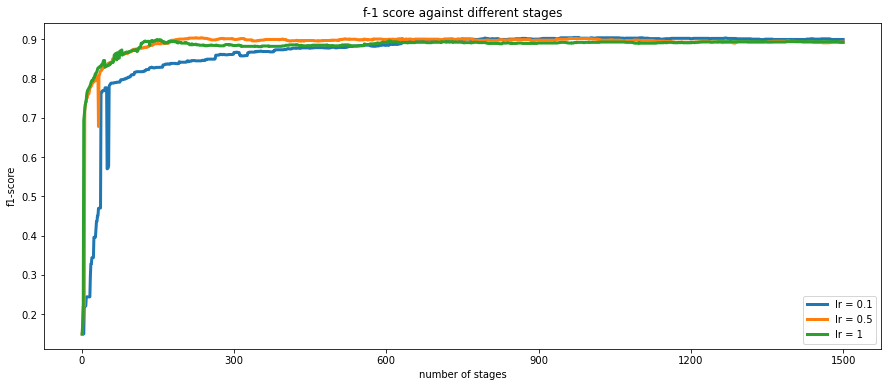

In [19]:
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt

plt.figure(figsize=(15,6))
learning_rate = [0.1,0.5,1]
lr_dict=dict()
for lr in learning_rate :
    gbc_clf = GradientBoostingClassifier(learning_rate=lr, n_estimators=1500, random_state=42)
    gbc_clf.fit(x_train.values,y_train.values)
    y_valid_pred = gbc_clf.staged_predict(x_valid.values)
    f1_list = [f1_score(y_valid, ypred) for ypred in y_valid_pred]
    bestn_idx = np.argmax(f1_list)
    best_n_estimators = bestn_idx+1
    bestf1 = f1_list[bestn_idx]
    lr_dict.update({lr:{'best_n_estimators':best_n_estimators,'bestf1':bestf1}})
    plt.plot(list(range(1,1501)),f1_list,label=f'lr = {lr}',lw=3)
    
plt.title('f-1 score against different stages')
plt.xlabel('number of stages')
plt.ylabel('f1-score')
plt.xticks([0,300,600,900,1200,1500])
plt.legend(loc='best')
plt.show()

### 找出最佳的Learning Rate (稱best_lr) 與其對應的Number of Stages(best_nstg)

In [20]:
best_lr,best_dict =sorted(list(lr_dict.items()),key=lambda x : x[1]['bestf1'],reverse=True)[0]
best_nstg = best_dict['best_n_estimators']

### 將Training與Validation合併

In [21]:
x_train_valid = np.vstack([x_train,x_valid])
y_train_valid = np.append(y_train,y_valid)

### 令learning_rate為best_lr, n_estimators為best_nstg，訓練最終模型，並報告Test Data的Accuracy, Precision, Recall, 與F-1 Score。另外列出最重要的20個特徵。

In [32]:
gbc_clf_best = GradientBoostingClassifier(learning_rate=best_lr,
                                          n_estimators=best_nstg,random_state=42)
gbc_clf_best.fit(x_train_valid,y_train_valid)
y_test_pred = gbc_clf_best.predict(x_test)
acc_gbc = accuracy_score(y_test, y_test_pred)
ps_gbc = precision_score(y_test, y_test_pred)
rs_gbc = recall_score(y_test, y_test_pred)
f1_gbc = f1_score(y_test, y_test_pred)
feat= gbc_clf_best.feature_importances_
top20_feature_idx = np.argsort(feat)[::-1][:20]
top20_feature_value = feat[top20_feature_idx]
top20_feature = x_train.columns[top20_feature_idx]
print('Best Learning Rate:',best_lr)
print('Best Number of Stages:',best_nstg,'\n')

print('Accuracy:',acc_gbc)
print('Precision:',ps_gbc)
print('Recall:',rs_gbc)
print('F-1 score:',f1_gbc)
gbc_pred_stat = np.array([acc_gbc,ps_gbc,rs_gbc,f1_gbc]).reshape(1,-1)
df_top20_gbc = pd.DataFrame(
    {'feature':top20_feature,'value':top20_feature_value.flatten()},index=range(1,21))
df_top20_gbc.index.name='rank'
df_top20_gbc

Best Learning Rate: 0.1
Best Number of Stages: 969 

Accuracy: 0.8693609022556391
Precision: 0.8270676691729323
Recall: 0.9034907597535934
F-1 score: 0.8635917566241413


feature     value
rank                  
1          妤  0.030437
2          翔  0.023131
3          萱  0.020491
4          柏  0.020009
5          婷  0.019191
6          哲  0.012953
7          蓁  0.012924
8          承  0.012877
9          怡  0.012876
10         雅  0.012098
11         晴  0.011942
12         宜  0.011599
13         柔  0.011598
14         佳  0.011533
15         芸  0.011176
16         涵  0.011040
17         芷  0.010774
18         瑄  0.010690
19         慈  0.010132
20         庭  0.010117

### 討論Prediction Performance與重要特徵的合理性

根據上面結果，預測準確率0.86，Recall準確率與Prcesion準確率的差距接近0.8是預測到目前為止最大的，整體來說預測結果介於Logistic Regression與Random Forest之間，然而不變的是前20名特徵清一色都是一個字，顯然一個字判別性別是比較精確的，但與RandomForestClassifier相同從特徵值很分辨出性別是男還是女，根據我的直覺猜測女生應該是佔大多數的。

#### Q1.5 (10%):
取用前面所建構的Logistic Regression, Random Forest, 與Gradient Boosting Decision Tree, 組合(Stacking)成一個新的分類器。我們使用Logistic Regression without Penalty建構這個Stacking分類器。訓練資料為Stacking資料集。各分類器輸入的特徵為男生預測機率(注意: 不是分類結果)。列出Stacking分類器的係數，討論係數的意義，並計算這個Stacking分類器在Test資料集的預測能力。

### 合併前面所建構的Logistic Regression, Random Forest, 與Gradient Boosting Decision Tree分類器預測stack訓練集的男性機率做為訓練Stacking分類器的特徵。

In [38]:
log_stack_prob = log_clf_bestc.predict_proba(x_stack)[:,1]
rfc_stack_prob = rfc_clf_best.predict_proba(x_stack)[:,1]
gbc_stack_prob = gbc_clf_best.predict_proba(x_stack)[:,1]

stack_train = np.hstack([log_stack_prob.reshape(-1,1),
                          rfc_stack_prob.reshape(-1,1),
                          gbc_stack_prob.reshape(-1,1)])

### 使用Logistic Regression without Penalty建構這個Stacking分類器。

In [39]:
stack_estimator = LogisticRegression(penalty='none',random_state=42,max_iter=1000)
stack_estimator.fit(stack_train,y_stack)
print('stack_estimator.coef:',stack_estimator.coef_)

stack_estimator.coef: [[2.96836082 0.20897088 4.88187931]]


### 列出Stacking分類器的係數，討論係數的意義。

我們可以看到Gradient Boosting Decision Tree分類器的係數(4.88)是當中最高的，因此整體來說會更偏向Gradient Boosting Decision Tree分類器

### 與前面訓練Stacking分類器特徵一樣，在預測Stacking分類器時應將前面所建構的Logistic Regression, Random Forest, 與Gradient Boosting Decision Tree分類器預測test預測集的男性機率合併做為特徵。

In [40]:
log_test_prob = log_clf_bestc.predict_proba(x_test)[:,1]
rfc_test_prob = rfc_clf_best.predict_proba(x_test)[:,1]
gbc_test_prob = gbc_clf_best.predict_proba(x_test)[:,1]

stack_test = np.hstack([log_test_prob.reshape(-1,1),
                        rfc_test_prob.reshape(-1,1),
                        gbc_test_prob.reshape(-1,1)])

### 計算這個Stacking分類器在Test資料集的預測能力。

In [41]:
y_test_pred = stack_estimator.predict(stack_test)
acc_stack = accuracy_score(y_test, y_test_pred)
ps_stack = precision_score(y_test, y_test_pred)
rs_stack = recall_score(y_test, y_test_pred)
f1_stack = f1_score(y_test, y_test_pred)

print('Accuracy:',acc_stack)
print('Precision:',ps_stack)
print('Recall:',rs_stack)
print('F-1 score:',f1_stack)

Accuracy: 0.8834586466165414
Precision: 0.8551859099804305
Recall: 0.8973305954825462
F-1 score: 0.875751503006012


### 將Stacking分類器與前面所建構的Logistic Regression, Random Forest, 與Gradient Boosting Decision Tree分類器所預測的結果列表比較

In [42]:
stack_pred_stat = np.array([acc_stack,ps_stack,rs_stack,f1_stack]).reshape(1,-1)

total_pred_stat = np.vstack([log_pred_stat,rfc_pred_stat,gbc_pred_stat,stack_pred_stat])

comparsion_df = pd.DataFrame(total_pred_stat,
                              columns=['Accuracy','Precision','Recall','F-1 score'],
                              index=['LogisticRegression','RandomForestClassifier',
                                     'GradientBoostingClassifier','StackingClassifier'])
comparsion_df

Accuracy  Precision    Recall  F-1 score
LogisticRegression          0.885338   0.861386  0.893224   0.877016
RandomForestClassifier      0.839286   0.813492  0.841889   0.827447
GradientBoostingClassifier  0.869361   0.827068  0.903491   0.863592
StackingClassifier          0.883459   0.855186  0.897331   0.875752

### 小結

從以上圖表我們可以看出LogisticRegression的準確率是裡面當中最高的，但也只比StackingClassifier高出一點點，推測可能原因跟模型隨機切分資料的random_state有關，因此我們也不應該判定透過Stacking對不同分類器的預測結果再進行訓練是無效的，只是提升的幅度可能真的有限。

## 第二題 [Data Visualization via Dimensionality Reduction]

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

stu_adm = pd.read_csv('ds/student_admission106.csv', encoding="utf-8", dtype=str)
uname = pd.read_csv('ds/univ_name106short1.csv', encoding="utf-8", dtype=str)

all_depid = stu_adm['department_id'].unique()
all_stuid = stu_adm['student_id'].unique()

ndepid = all_depid.shape[0]
nstuid = all_stuid.shape[0]
print("There are %d students and %d departments in total." % (nstuid, ndepid))

print("offers received by students:")
stu_adm.head(10)

There are 60461 students and 1976 departments in total.
offers received by students:


school_id department_id student_id student_name state location1 location2
0       001        001012   10246842          黃士玹    正1        南部      台南考區
1       001        001012   10042237          黃冠婷    正2        北部      台北考區
2       001        001012   10008031          鍾大方    正3        北部      台北考區
3       001        001012   10201525          曾信豪    正4        中部      彰化考區
4       001        001012   10014615          陳品儒    正5        北部      台北考區
5       001        001012   10294018          侯思筠    正6        東部      宜蘭考區
6       001        001012   10022810          吳悅慈    正7        北部      台北考區
7       001        001012   10236223          陳俞潔    正8        南部      台南考區
8       001        001012   10025909          蕭宇廷    正9        北部      台北考區
9       001        001012   10123708          吳岱軒   正10        北部      中壢考區

The department_id can uniquely identify an academic department. We do not care about the ranking of admission here, and you should ignore the "state" column. We only care about the "co-application" relations in this dataset. You should use student_id to identify a student applicant uniquely. 

In [4]:
print("academic department basic information:")
uname.head(10)

academic department basic information:


year school_id department_id school_name department_name category_id  \
0  106       006        006042      國立政治大學            教育學系           1   
1  106       006        006052      國立政治大學       教育學系(公費生)           1   
2  106       006        006062      國立政治大學    教育學系(原住民公費生)           1   
3  106       006        006022      國立政治大學            歷史學系           2   
4  106       006        006152      國立政治大學            民族學系           2   
5  106       006        006032      國立政治大學             哲學系           2   
6  106       006        006262      國立政治大學          英國語文學系           2   
7  106       006        006292      國立政治大學          日本語文學系           2   
8  106       006        006272      國立政治大學         阿拉伯語文學系           2   
9  106       006        006302      國立政治大學          韓國語文學系           2   

  category_name school_name_abbr department_name_abbr  
0            教育               政大                   教育  
1            教育               政大                教育(公)  
2            教育               政大              教育(原住民)  
3         藝術及人文               政大                   歷史  
4         藝術及人文               政大                  民族學  
5         藝術及人文               政大                   哲學  
6         藝術及人文               政大                 英國語文  
7         藝術及人文               政大                 日本語文  
8         藝術及人文               政大                阿拉伯語文  
9         藝術及人文               政大                 韓國語文

You can use this dataset to identify the name of a department_id. The school_name and department_name contain the "full name" of an academic department. To facilitate visualization, we also provide "shorter names" in school_name_abbr and department_name_abbr. The category_name is the field of an academic department. This field is essential in our visualization exercise since you should color each data point according to its category_name. 

### Data Preparation
Our focus is on the relationships between departments. To do this, we need to convert the raw data into a "matrix" representation. Each row represents an academic department, and each column represents a student applicant. The cell's value is one if a student applied for admission to the corresponding academic department, and 0 otherwise. 

To avoid potential numerical problems, we only include an academic department if it received ten or more applications. Moreover, we only include a student applicant if he or she applied for more than one academic department. 

Note that the two conditions should be satisfied "as is" in after preprocessing. For example, suppose a student applied for two departments in the original dataset, and one of the departments was removed. In that case, this student should be removed because the student only applied for one department in the processed dataset. 

In [8]:
%matplotlib inline
import numpy as np
import pandas as pd

stu_adm = pd.read_csv('ds/student_admission106.csv', encoding="utf-8", dtype=str)
uname = pd.read_csv('ds/univ_name106short1.csv', encoding="utf-8", dtype=str)

all_depid = stu_adm['department_id'].unique()
all_stuid = stu_adm['student_id'].unique()

ndepid = all_depid.shape[0]
nstuid = all_stuid.shape[0]
print("In raw data, there are %d students and %d departments in total." % (nstuid, ndepid))

#construct the department-student matrix (i.e. array). 
dep_stu = np.zeros((ndepid, nstuid))
rowname = all_depid.copy()

depid_seq_map = dict()
for i in range(ndepid):
    depid_seq_map[all_depid[i]] = i

stuid_seq_map = dict()
for i in range(nstuid):
    stuid_seq_map[all_stuid[i]] = i

for cindex, row in stu_adm.iterrows():
    #print(cindex, row)
    dep_seq = depid_seq_map[row['department_id']]
    stu_seq = stuid_seq_map[row['student_id']]
    #print(dep_seq, stu_seq)
    dep_stu[dep_seq, stu_seq] = 1

#Remove very small departments.
min_stu_per_dep = 10
min_apply_dep_per_stu = 2

#remove small departments and single-application students. 
dep_apply_sum = np.sum(dep_stu, axis = 1)
keeprow = dep_apply_sum >= min_stu_per_dep
rowname = rowname[keeprow]
dep_stu2 = dep_stu[keeprow,:]
stu_apply_sum = np.sum(dep_stu2, axis = 0)
dep_stu2 = dep_stu2[:, stu_apply_sum >= min_apply_dep_per_stu]

#another run of filtering
dep_apply_sum = np.sum(dep_stu2, axis = 1)
dep_stu2 = dep_stu2[dep_apply_sum >= min_stu_per_dep,:]
rowname = rowname[dep_apply_sum >= min_stu_per_dep]
stu_apply_sum = np.sum(dep_stu2, axis = 0)
dep_stu2 = dep_stu2[:, stu_apply_sum >= min_apply_dep_per_stu]

#third run of filtering
dep_apply_sum = np.sum(dep_stu2, axis = 1)
dep_stu2 = dep_stu2[dep_apply_sum >= min_stu_per_dep,:]
rowname = rowname[dep_apply_sum >= min_stu_per_dep]

stu_apply_sum = np.sum(dep_stu2, axis = 0)
dep_stu2 = dep_stu2[:, stu_apply_sum >= min_apply_dep_per_stu]

#check to make sure the two conditions are satisfied. 
dep_apply_sum = np.sum(dep_stu2, axis = 1)
print("Number of department too small:", np.sum(dep_apply_sum < min_stu_per_dep))
stu_apply_sum = np.sum(dep_stu2, axis = 0)
print("Number of students applying only one department:", np.sum(stu_apply_sum <min_apply_dep_per_stu))

#now both conditions are satisfied.

In raw data, there are 60461 students and 1976 departments in total.


MemoryError: Unable to allocate 911. MiB for an array with shape (1976, 60461) and data type float64

In [ ]:
num_dep, num_stu = dep_stu2.shape
print("In final dataset, there are", num_dep, "academic departments and", num_stu, "student applicants.")

Report the top ten departments that received the most applications and the number of applications they received:

In [ ]:
uname['depname'] = uname.school_name_abbr + uname.department_name_abbr
uname2 = uname[['department_id', 'depname', 'category_name']].copy()
#this is for later use, to color data points. 
category_id, category_levels = pd.factorize(uname2.category_name)
#uname2['category_id'] = category_id / np.max(category_id)
uname2['category_id'] = category_id

#create a data frame for column name
colname_df = pd.DataFrame({'department_id': rowname})
colname_df = colname_df.merge(uname2, how = "left", on="department_id")

In [ ]:
topdepid = np.argsort(dep_apply_sum)[::-1]
topn = 10
topdep = pd.DataFrame({'department_id': rowname[topdepid[0:topn]], 
                       'department_name': colname_df.depname.values[topdepid[0:topn]],
                       'num_applicant': dep_apply_sum[topdepid[0:topn]]
                       }) 
topdep

#### Q2.1 (10%): Visualize academic departments using the first eight principal components. Use your judgment to select multiple pairs of principal components to visualize. Discuss the visual patterns concerning department categories. 

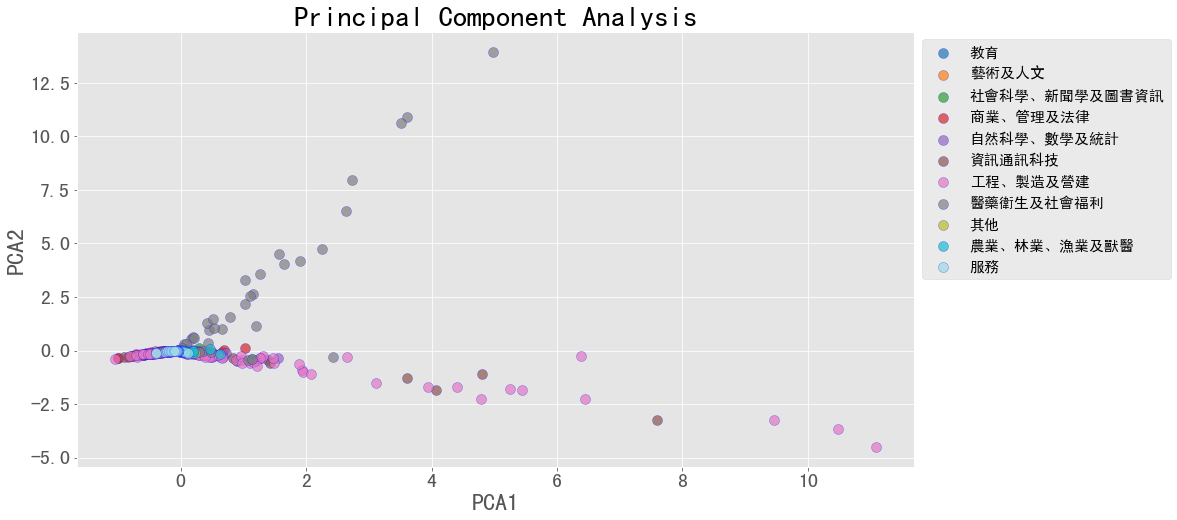

In [49]:
category_dict = {k: v.unique()[0] for k, v in (colname_df.groupby('category_id')['category_name'])}
from sklearn.decomposition import PCA
import matplotlib as mpl
import warnings

warnings.filterwarnings("ignore")


mpl.style.use('ggplot')
pca = PCA(n_components=8, random_state=0) # using the first eight principal components
dep_stu2_pca = pca.fit_transform(dep_stu2)

def dimension_reduction_visualization(x,y,xlabel,ylabel,title):
    plt.figure(figsize=(15,8))
    font = {'family' : 'SimHei', 'weight' : 'bold', 'size' : 20} 
    mpl.rc('font', **font)
    plt.rcParams['axes.unicode_minus'] = False 
    cmap_list = mpl.cm.get_cmap('tab20',11).colors
    for num in range(len(category_dict)):
        cat_idx = colname_df[colname_df['category_id']==num].index
        plt.scatter(x[cat_idx],y[cat_idx],color=cmap_list[num],s=100,alpha=0.7,linewidths=.3,
                    edgecolors='b',label=category_dict[num])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left',prop={'size': 15, 'weight': 'bold'})
    plt.show()
    
x=dep_stu2_pca[:,0]
y=dep_stu2_pca[:,1]
dimension_reduction_visualization(x, y,'PCA1', 'PCA2', 'Principal Component Analysis')

根據上圖表經過PCA降維之後，取第一主成分跟第二主成分來作圖可以看出`醫藥衛生及社會`類別被集中分在圖表的上半部，`工程、製造及營建`類別被分在圖表的下半部分，圖表左半部分則呈現大混亂的局勢，所有的類別都擠在一起，無法看出明顯分群。

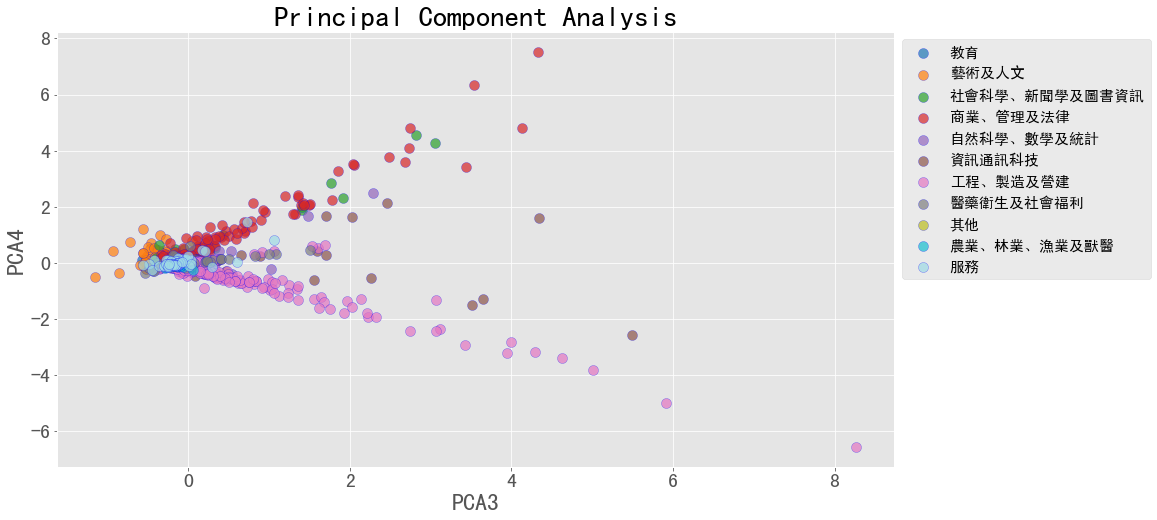

In [52]:
x=dep_stu2_pca[:,2]
y=dep_stu2_pca[:,3]
dimension_reduction_visualization(x, y,'PCA3', 'PCA4', 'Principal Component Analysis')

根據上圖表經過PCA降維之後，取第三主成分跟第四主成分來作圖可以看出`商業、管理及法律`被集中分在圖表的上半部分，`工程、製造及營建`類別一樣被分在圖表下半部分，`藝術及人文`被集中分在圖表的最左半邊，剩下類別則都高度重疊在左半部分(`藝術及人文`右邊)

#### Q2.2 (10%): Visualize academic departments using multiple dimensional scaling. Consider both the metric and non-metric settings. Discuss the result. 

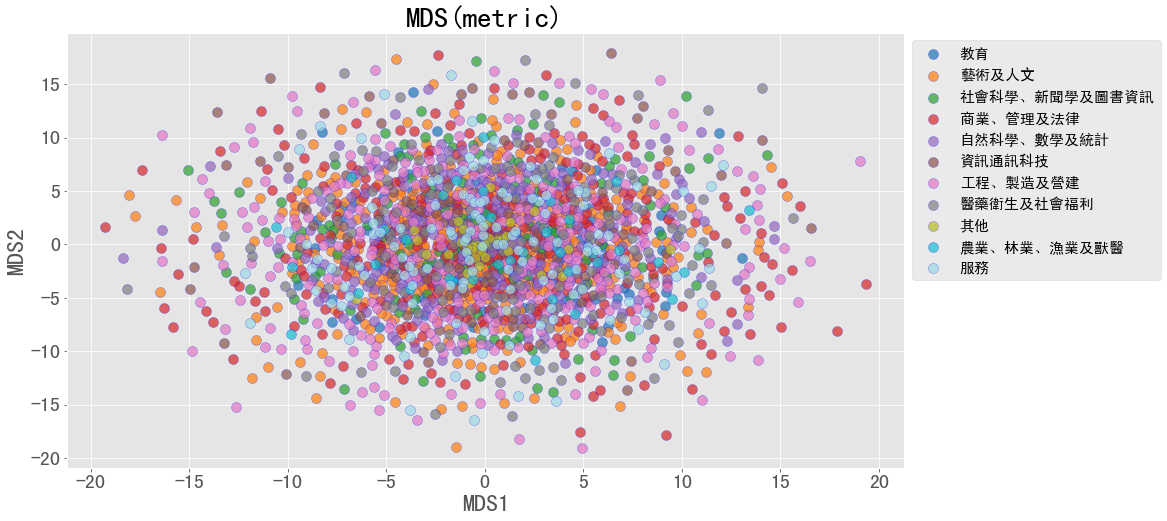

In [56]:
from sklearn.manifold import MDS
mds_metrics = MDS(n_components=2,metric=True,random_state=42)
dep_stu2_mds_metric = mds_metrics.fit_transform(dep_stu2)
x=dep_stu2_mds_metric[:,0]
y=dep_stu2_mds_metric[:,1]
dimension_reduction_visualization(x, y,'MDS1', 'MDS2', 'MDS(metric)')

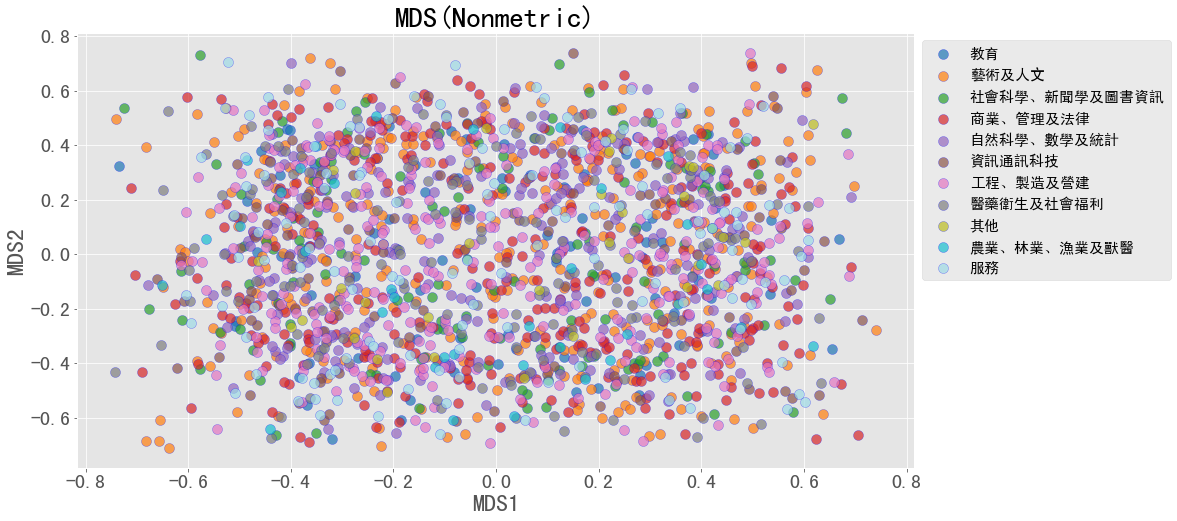

In [57]:
mds_metrics = MDS(n_components=2,metric=False,random_state=42)
dep_stu2_mds_nonmetric = mds_metrics.fit_transform(dep_stu2)
x=dep_stu2_mds_nonmetric[:,0]
y=dep_stu2_mds_nonmetric[:,1]
dimension_reduction_visualization(x, y,'MDS1', 'MDS2', 'MDS(Nonmetric)')

### 小結

從上方圖表可以發現不管是`Metric`還是`NonMetric`經過MDS降維都無法看出明顯分群的趨勢，都呈現非常混亂的局勢

#### Q2.3 (10%): Visualize academic departments using Locally Linear Embedding. Consider three variations: (1) Use 20 neighbors to construct the weight matrix; (2) Use 40 neighbors to construct the weight matrix; (3) Perform PCA transformation first, and use the first 100 principal components as the input to LLE (with 20 neighbors). Discuss the result. 

##### (1) Use 20 neighbors to construct the weight matrix

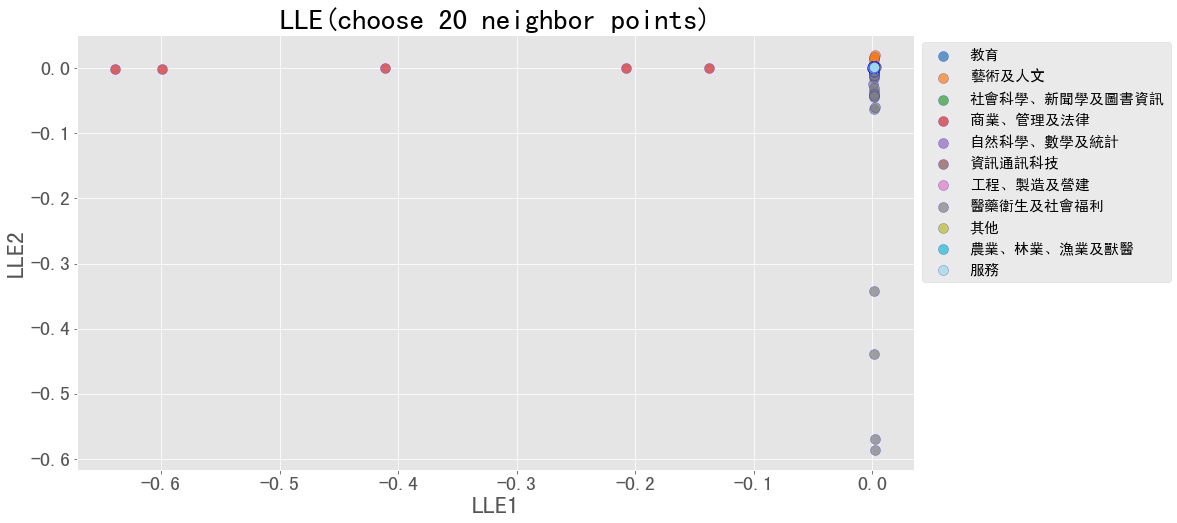

In [59]:
from sklearn.manifold import LocallyLinearEmbedding
lle20 = LocallyLinearEmbedding(n_neighbors=20,n_components=2,random_state=42)
dep_stu2_lle20 = lle20.fit_transform(dep_stu2)
x=dep_stu2_lle20[:,0]
y=dep_stu2_lle20[:,1]
dimension_reduction_visualization(x, y, 'LLE1', 'LLE2', 'LLE(choose 20 neighbor points)')

##### (2) Use 40 neighbors to construct the weight matrix

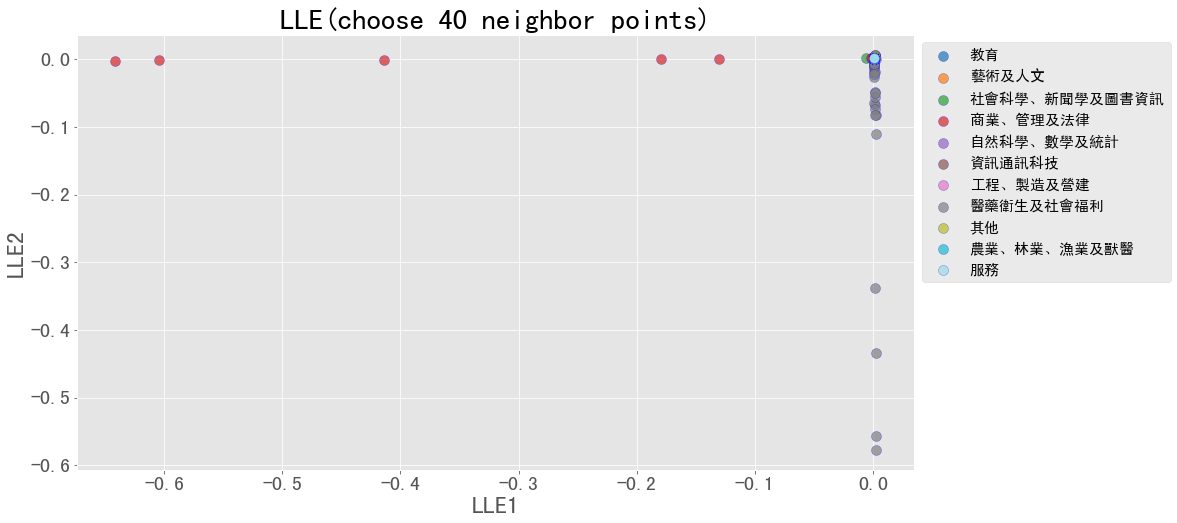

In [60]:
lle40 = LocallyLinearEmbedding(n_neighbors=40,n_components=2,random_state=42)
dep_stu2_lle40 = lle40.fit_transform(dep_stu2)
x=dep_stu2_lle40[:,0]
y=dep_stu2_lle40[:,1]
dimension_reduction_visualization(x, y, 'LLE1', 'LLE2', 'LLE(choose 40 neighbor points)')

##### (3) Perform PCA transformation first, and use the first 100 principal components as the input to LLE (with 20 neighbors)

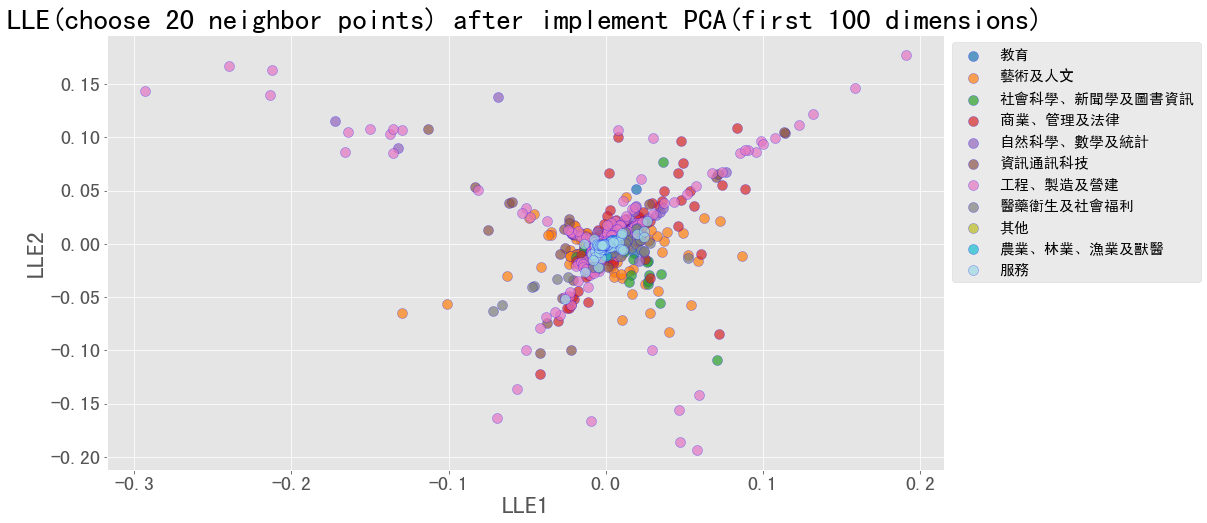

In [96]:
pca = PCA(n_components=100, random_state=42)
dep_stu2_pca100 = pca.fit_transform(dep_stu2)
pca_lle20 = LocallyLinearEmbedding(n_neighbors=20,n_components=2,random_state=42)
dep_stu2_pca_lle20 = pca_lle20.fit_transform(dep_stu2_pca100)
x=dep_stu2_pca_lle20 [:,0]
y=dep_stu2_pca_lle20 [:,1]
dimension_reduction_visualization(x, y, 'LLE1', 'LLE2', 'LLE(choose 20 neighbor points) after implement PCA(first 100 dimensions)')

### 小結

本題第一、二小題不管取20個還是40個鄰居呈現的結果都差不多，類別都集中在右上方角落，因此著重說明有無進行PCA前處理所呈現結果的不同，我們可以看出經過PCA前處理分群結果有好上一些，推測原因可能是PCA將雜訊過濾掉，並找出比較好的特徵，但整體而言還是呈現非常混亂，因此LLE在這題來說可能不是一個適合的方法。

#### Q2.4 (10%): Visualize academic departments using Kernel PCA. You should at least consider the RBF and Cosine kernel. It is your responsibility to select reasonably good kernel parameters. Discuss the result. 

#### RBF

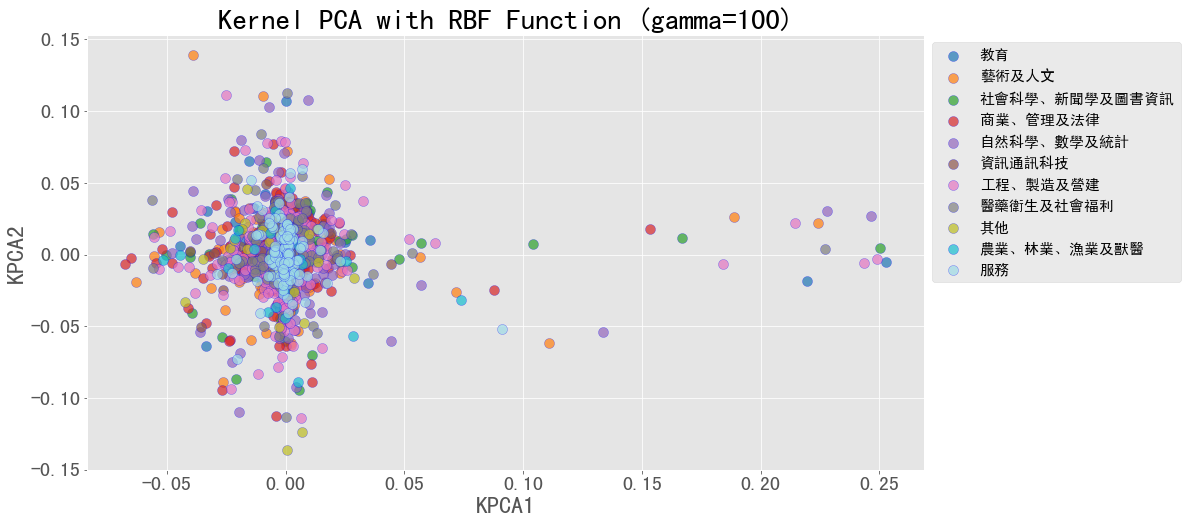

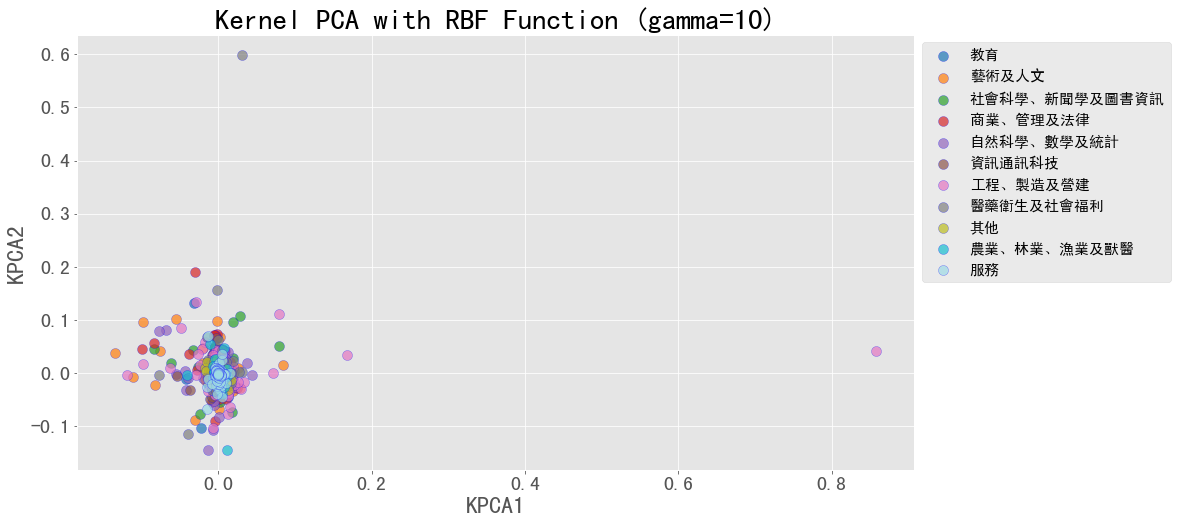

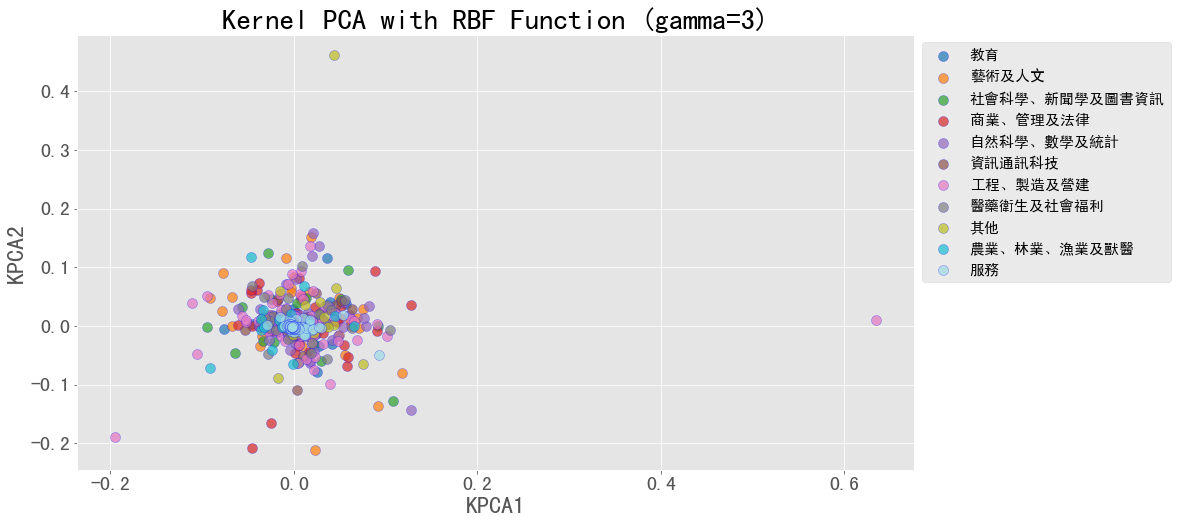

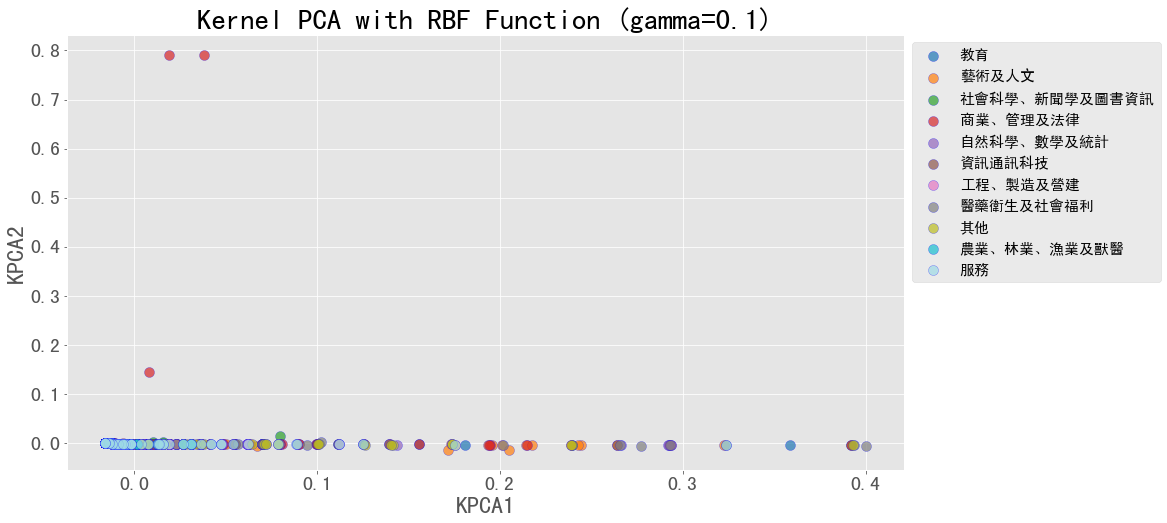

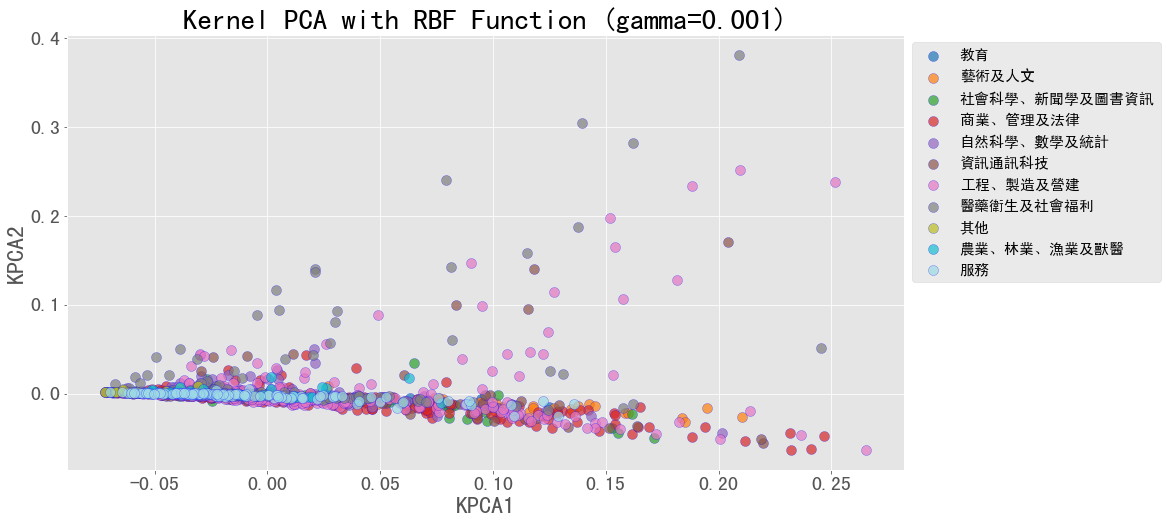

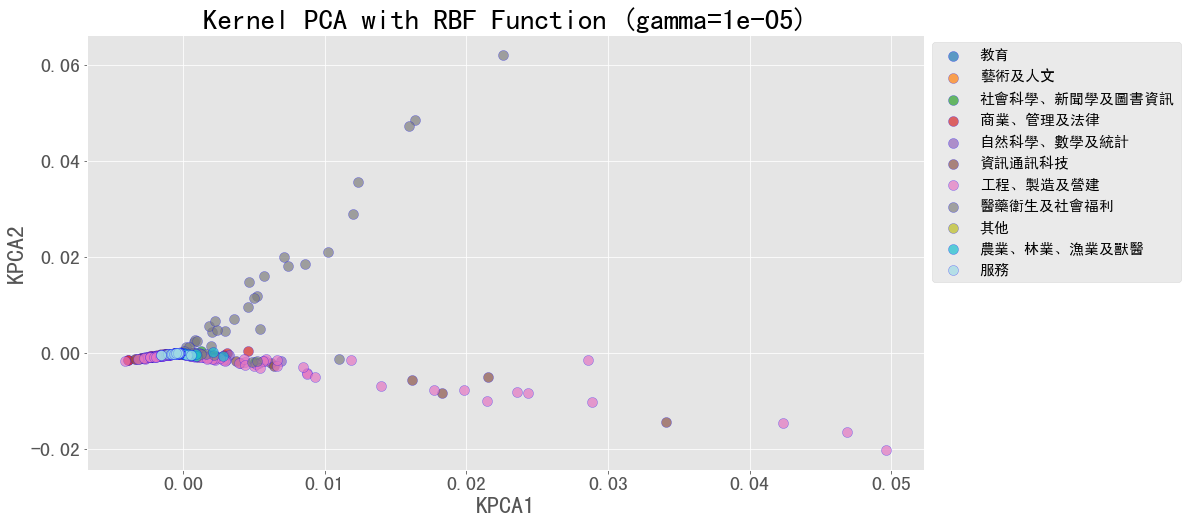

In [100]:
from sklearn.decomposition import KernelPCA
gamma_params = [100,10,3,0.1,0.001,0.00001]
for gamma in gamma_params:
    kpca_rbf = KernelPCA(n_components=2,kernel='rbf',random_state=42,gamma=gamma)
    dep_stu2_rbf = kpca_rbf.fit_transform(dep_stu2)
    x=dep_stu2_rbf[:,0]
    y=dep_stu2_rbf[:,1]
    dimension_reduction_visualization(x, y, 'KPCA1', 'KPCA2', f'Kernel PCA with RBF Function (gamma={gamma})')

從上方測試不同gamma值所呈現的分群結果，可以看出gamma小到10e-5時會有比較明顯的分群結果，`醫藥衛生及社會福利`被分在上半部分，`工程、製造及營建`勉強被分在下半部分，剩餘的gamma還是呈現高度重疊、混亂的情勢

#### Cosine

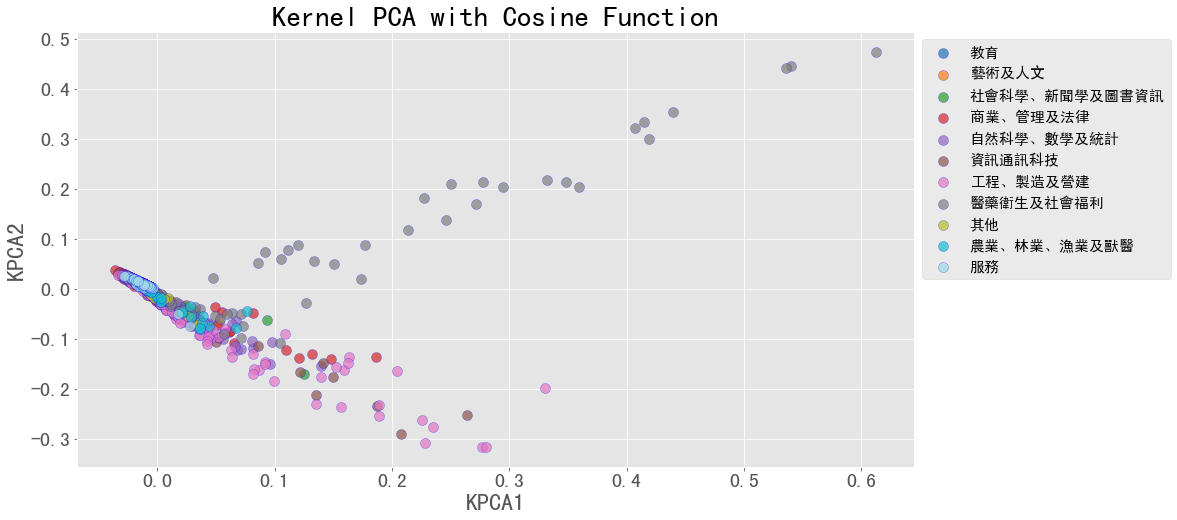

In [67]:
kpca_cos = KernelPCA(n_components=2,kernel='cosine',random_state=42)
dep_stu2_cos = kpca_cos.fit_transform(dep_stu2)
x=dep_stu2_cos[:,0]
y=dep_stu2_cos[:,1]
dimension_reduction_visualization(x, y, 'KPCA1', 'KPCA2', 'Kernel PCA with Cosine Function')

我們可以看出使用`Cosine`kernel比`RBF`kernel來的好，`醫藥衛生及社會福利`被分在右上部分，`工程、製造及社會福利`勉強集中在下半部分，但嚴格來說不管是使用`Cosine`kernel或`RBF`kernel大多數的類別還是呈現高度重疊、混亂的局勢。

#### Q2.5 (10%): Visualize academic departments using t-SNE. You should consider at least the Euclidian, Cosine, and Jaccard metric. Set numpy random seed so that your results can be repeated. Discuss the result. 

##### Use Euclidian metric

In [7]:
from sklearn.manifold import TSNE
np.random.seed(42)
tsne_ecu = TSNE(n_components=2,metric='euclidean',random_state=42)
dep_stu2_tsne_ecu = tsne_ecu.fit_transform(dep_stu2)
x = dep_stu2_tsne_ecu[:,0]
y = dep_stu2_tsne_ecu[:,1]
dimension_reduction_visualization(x, y, 't-SNE1', 't-SNE2', 't-SNE with Euclidean Method')

NameError: name 'dep_stu2' is not defined

##### Use Cosine metric

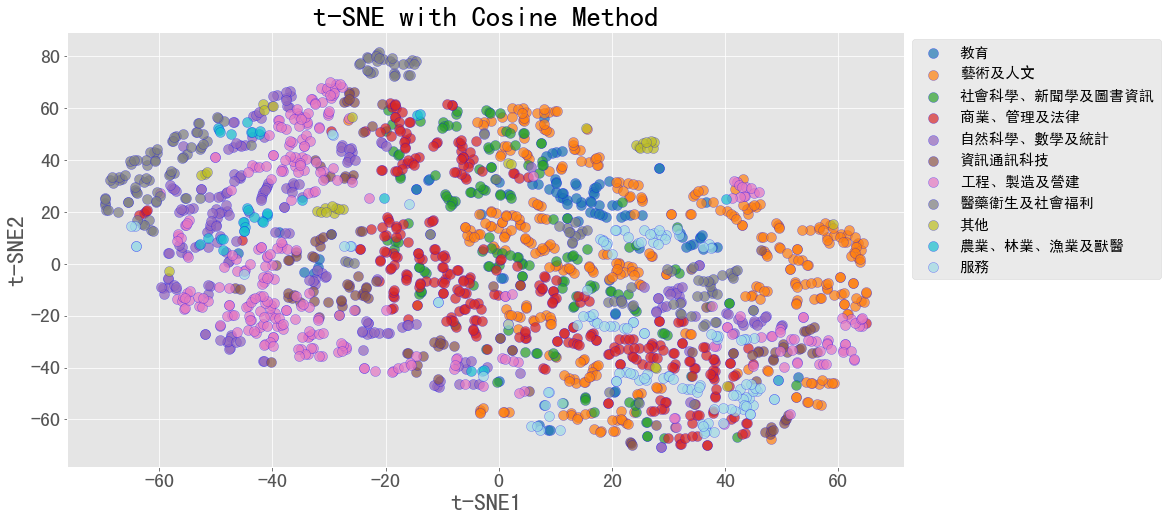

In [71]:
tsne_cos = TSNE(n_components=2,metric='cosine',random_state=42)
np.random.seed(42)
dep_stu2_tsne_cos = tsne_cos.fit_transform(dep_stu2)
x = dep_stu2_tsne_cos[:,0]
y = dep_stu2_tsne_cos[:,1]
dimension_reduction_visualization(x, y, 't-SNE1', 't-SNE2', 't-SNE with Cosine Method')

##### Use Jaccard metric

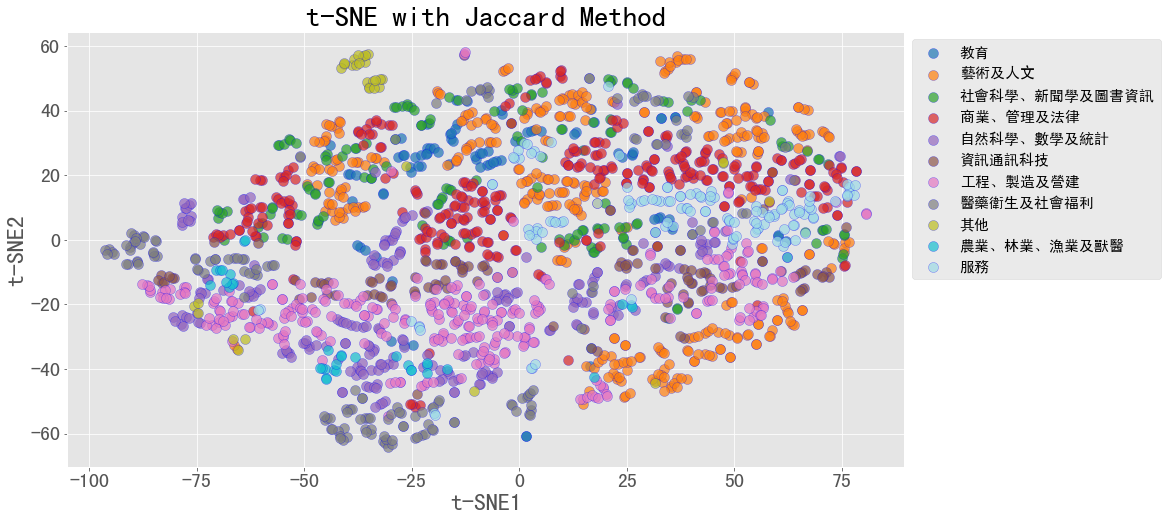

In [72]:
tsne_jac = TSNE(n_components=2,metric='jaccard',random_state=42)
np.random.seed(42)
dep_stu2_tsne_jac = tsne_jac.fit_transform(dep_stu2)
x = dep_stu2_tsne_jac[:,0]
y = dep_stu2_tsne_jac[:,1]
dimension_reduction_visualization(x, y, 't-SNE1', 't-SNE2', 't-SNE with Jaccard Method')

### 小結

從以上圖表我們可以看出使用`Euclidian`方法分群結果是最差的，所有類別都高度重疊擠在一起，而使用`Cosine`及`Jaccard`方法分群結果是比較好的，有將各自類別集中在某個部分的趨勢，也是到目前為止分群結果最好的。

#### Q2.6 (10%) Select the most promising visualization method in the previous question and refine the result. You should color points by department category. Label each data point with its name so that we can quickly identify a data point on the picture. Moreover, you should try to reduce the problem caused by overlapping points and labels. Output an image that is large enough so that a user can easily identify a department and its neighbors. Jupyter Lab has limitations on the largest picture size. To overcome this problem, output the picture to a separate file and submit the file for grading. Your score depends on how useful, readable, and visually pleasing of your visualization results. 

In [129]:
import plotly
import plotly.express as px
import plotly.io as pio
def visual_with_dept_name(x, y, xlabel, ylabel, title):
    colname_df_tmp = colname_df.copy()
    colname_df_tmp['x']=x
    colname_df_tmp['y']=y
    scatterplot = px.scatter(data_frame=colname_df_tmp,x='x',y='y',color='category_name',
                             opacity=.7,text='depname',hover_name='depname',
                             hover_data=['category_name'],labels={'x':xlabel,'y':ylabel,
                                                                  'category_name':'類別','depname':'系所'},
                             title=title,width=3000,height=2400,template='plotly_white')
    scatterplot.update_traces(marker=dict(size=20),textposition='top center',textfont=dict(size=10,family='SimHei'))
    pio.write_image(scatterplot,'hw3_result.png',format='png')
    pio.show(scatterplot,renderer='notebook')
                             


tsne_cos = TSNE(n_components=2, metric='cosine', random_state=42)
dep_stu2_tsne_cos = tsne_cos.fit_transform(dep_stu2)
x = dep_stu2_tsne_cos[:, 0]
y = dep_stu2_tsne_cos[:, 1]
visual_with_dept_name(x, y, 't-SNE1', 't-SNE2', 't-SNE with Cosine Method')

### 小結

延續前一題提到`Cosine`及`Jaccard`方法有到目前為止比較好的分群結果，考量兩者的處理時間決定使用`Cosine`方法做為本題畫圖的`visualization method`，這邊使用`Plotly`套件作圖，與`Matplotlib`、`Seaborn`相比能更好的與使用者互動，從圖表中的點點我們可以很清楚看到對應的系所和類別，最後因為礙於notebook cell 大小的關係可能無法看到完整的圖，因此附上網路連結(https://hopeful-panini-852c51.netlify.app/)